 참고
- Time series Basics : Exploring traditional TS
- https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts
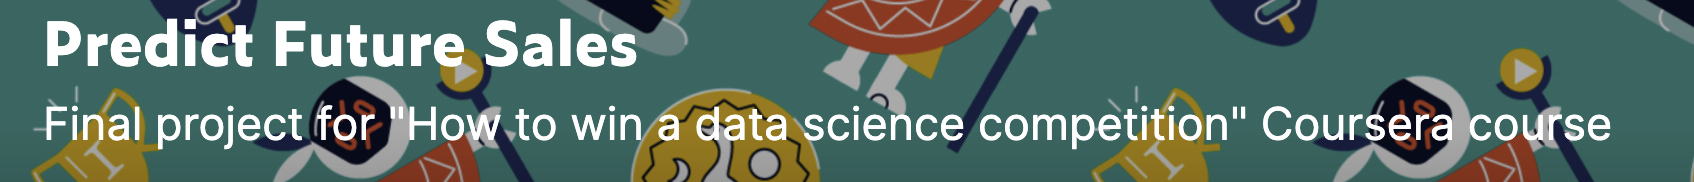


## 특성 파악
    * Stationarity
    * Seasonality , Trend and Remainder
    * AR , MA , ARMA , ARIMA
    * Selecting P and Q using AIC
    * ETS
    * Prophet 
    * UCM
    
    
## 목적

- 상품별 월별 매출액 예측

## train 데이터
ID -  (Shop, Item)를 구분  
shop_id   
item_id  
item_category_id  
item_cnt_day - 판매량, 월별 예측이 목적변수임  
item_price - 현재 가격  
date - dd/mm/yyyy  
date_block_num - 월 순서번호 2013.1월이 0, 2015.10월이 33  
item_name - 상품명  
shop_name - 상점명  
item_category_name - 카테고리명  

In [3]:
import numpy as np
import pandas as pd
import random as rd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")

In [15]:
!curl -L https://bit.ly/3aNJ9dG -o shop.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   178  100   178    0     0    642      0 --:--:-- --:--:-- --:--:--   642
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1034    0  1034    0     0    551      0 --:--:--  0:00:01 --:--:--     0
100 15.5M  100 15.5M    0     0  3555k      0  0:00:04  0:00:04 --:--:-- 8335k


In [16]:
!unzip shop.zip

Archive:  shop.zip
   creating: competitive-data-science-predict-future-sales/
  inflating: __MACOSX/._competitive-data-science-predict-future-sales  
  inflating: competitive-data-science-predict-future-sales/sales_train.csv  
  inflating: __MACOSX/competitive-data-science-predict-future-sales/._sales_train.csv  
  inflating: competitive-data-science-predict-future-sales/shops.csv  
  inflating: __MACOSX/competitive-data-science-predict-future-sales/._shops.csv  
  inflating: competitive-data-science-predict-future-sales/test.csv  
  inflating: __MACOSX/competitive-data-science-predict-future-sales/._test.csv  
  inflating: competitive-data-science-predict-future-sales/item_categories.csv  
  inflating: __MACOSX/competitive-data-science-predict-future-sales/._item_categories.csv  
  inflating: competitive-data-science-predict-future-sales/items.csv  
  inflating: __MACOSX/competitive-data-science-predict-future-sales/._items.csv  
  inflating: competitive-data-science-predict-future-s

In [4]:
path = "./competitive-data-science-predict-future-sales"

In [5]:
!ls comp*

item_categories.csv   sales_train.csv       shops.csv
items.csv             sample_submission.csv test.csv


In [6]:
sales=pd.read_csv(path+"/sales_train.csv")
item_cat=pd.read_csv(path+"/item_categories.csv")
item=pd.read_csv(path+"/items.csv")
sub=pd.read_csv(path+"/sample_submission.csv")
shops=pd.read_csv(path+"/shops.csv")
test=pd.read_csv(path+"/test.csv")

In [81]:
sales[:2]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [82]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [83]:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [86]:
sales[:2]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0


In [7]:
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)

In [8]:
monthly_sales.head(10)

date             item_price item_cnt_day
                                       min         max       mean          sum
date_block_num shop_id item_id                                                
0              0       32       03.01.2013  31.01.2013      221.0          6.0
                       33       03.01.2013  28.01.2013      347.0          3.0
                       35       31.01.2013  31.01.2013      247.0          1.0
                       43       31.01.2013  31.01.2013      221.0          1.0
                       51       13.01.2013  31.01.2013      128.5          2.0
                       61       10.01.2013  10.01.2013      195.0          1.0
                       75       17.01.2013  17.01.2013       76.0          1.0
                       88       16.01.2013  16.01.2013       76.0          1.0
                       95       06.01.2013  06.01.2013      193.0          1.0
                       96       10.01.2013  10.01.2013       70.0          1.0

In [9]:
monthly_sales.shape

(1609124, 4)

In [10]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


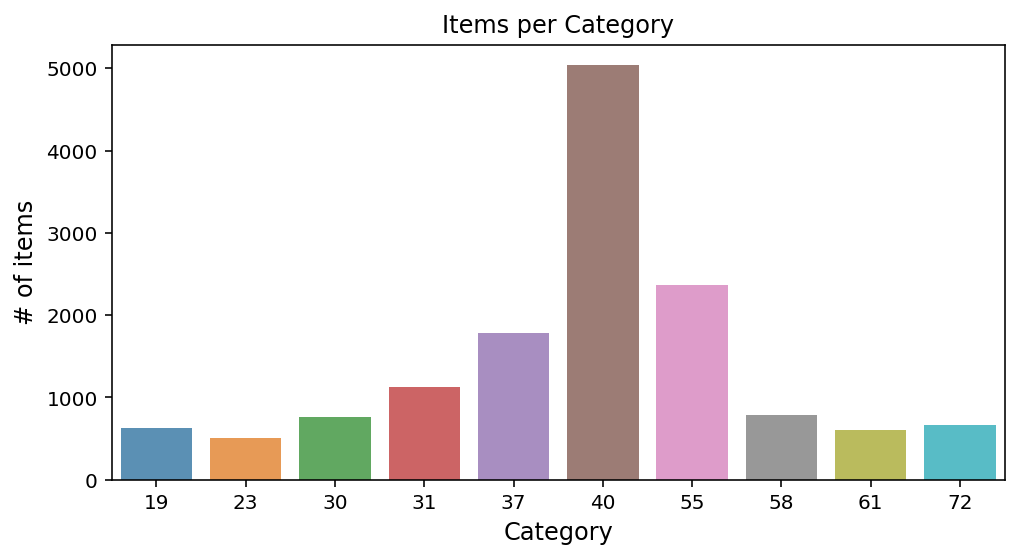

In [11]:

plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

## 시리즈
- 상점-아이템별 다음달 매출 예측
- 먼저 전체 매출에 대한 예측 수행

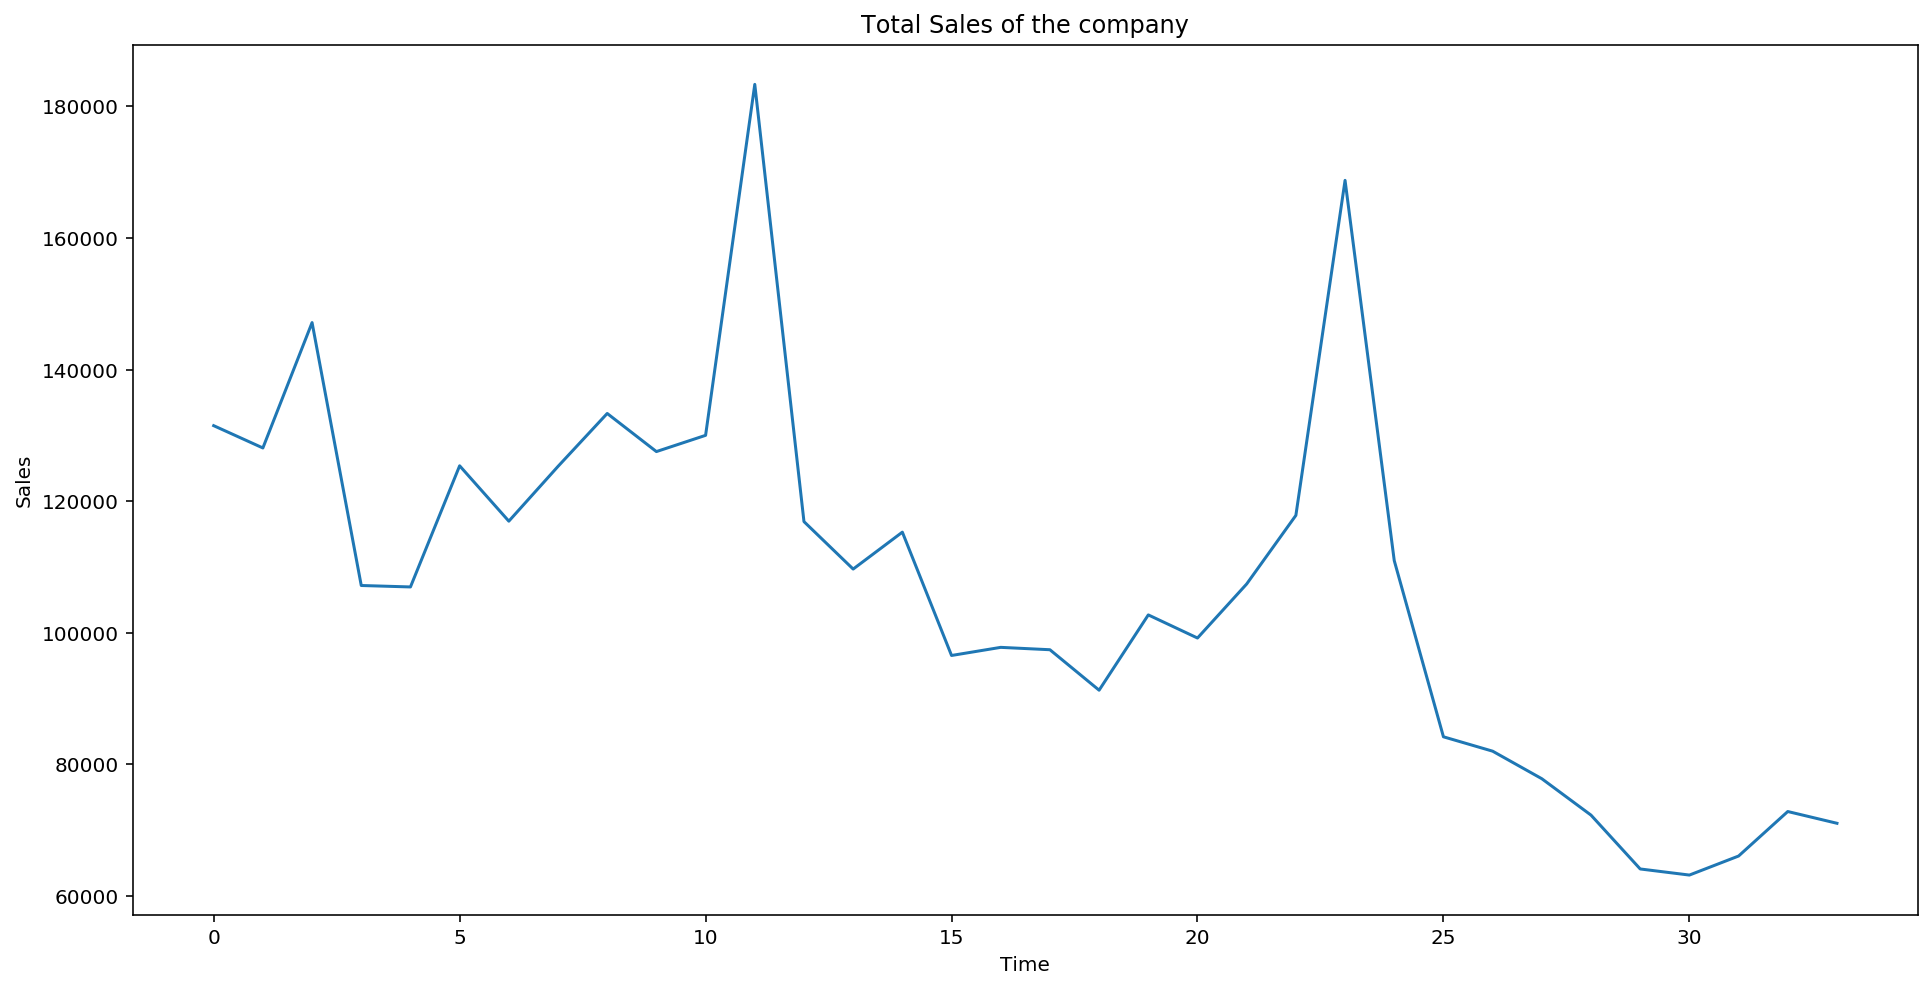

In [12]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

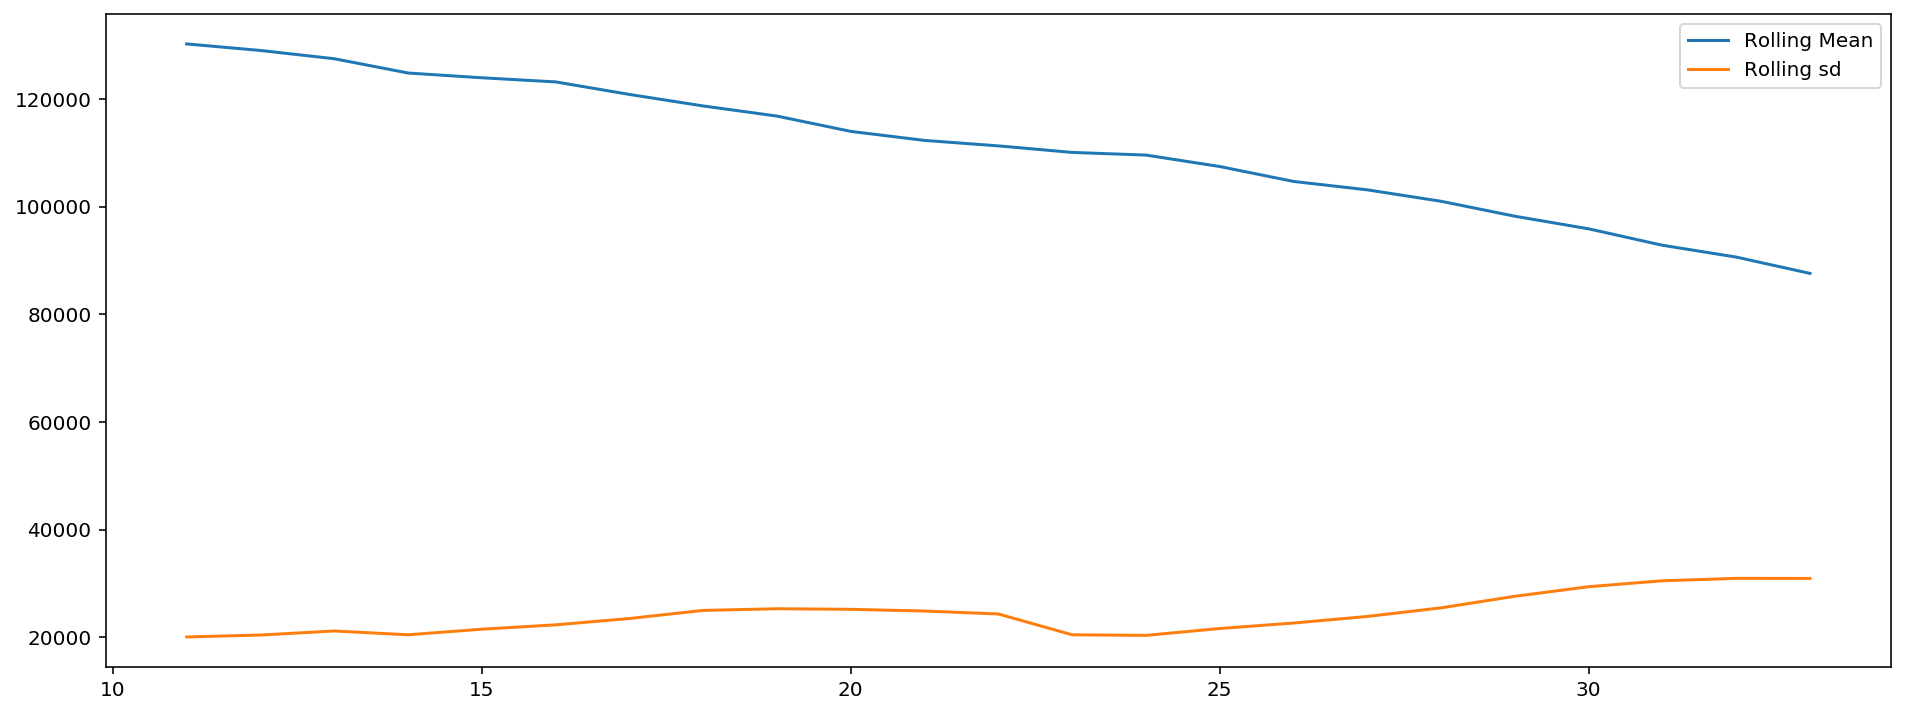

In [95]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

- 감소하는 트렌드와 계절성이 있다.
- 이를 분해하는 함수로 덧셈형과 곱셈형이 있다

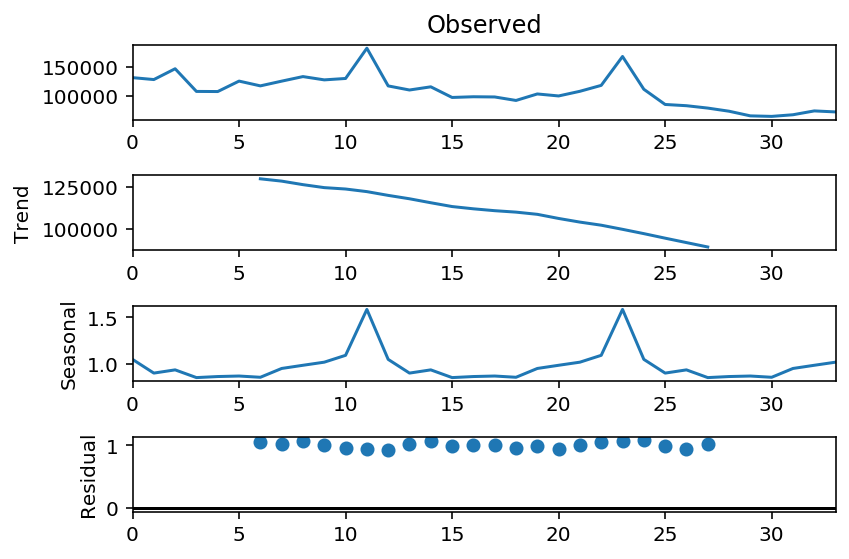

In [96]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()

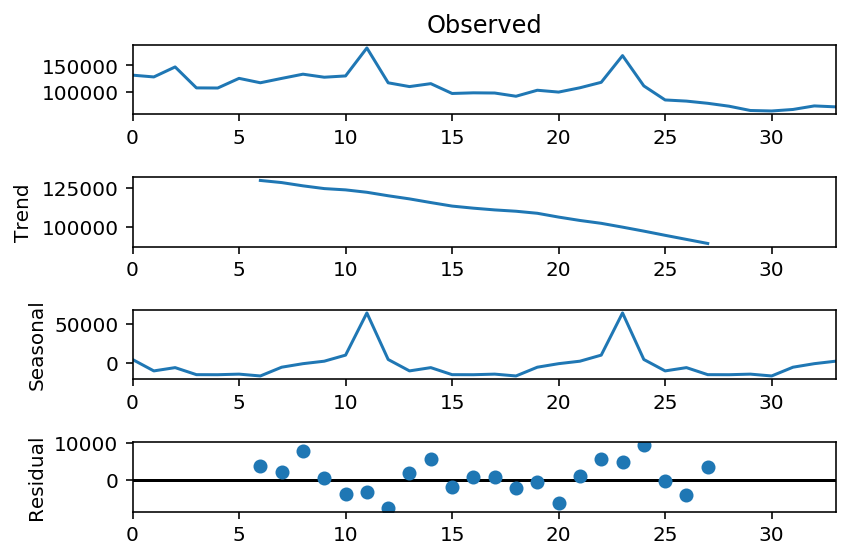

In [97]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

- 덧셈형 모델 (주기: t)

> yt=St+Tt+Et 

- 곱셈형 모델 

> yt=St  x Tt x Et 

## 시불변성(Stationarity)

![q](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

- 시불변 데이터의 분석은 용이하다
- 통계적 분석은 시불변 데이터만 가능하다
- 시불변성을 검사하는 방법
 * ADF( Augmented Dicky Fuller Test)-가장 널리 사용된다. 
 * KPSS 
 * PP (Phillips-Perron test)

Note: [Step by step guide to perform dicky fuller test in Excel](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/)

[Another Useful guide](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#AR) 

[good reference](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)


In [45]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)


Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [98]:
# 트렌드 제거
from pandas import Series as Series
# 차분 값 (differenced) 시리즈 생성
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# 원래 값으로 환원
def inverse_difference(last_ob, value):
    return value + last_ob

[]

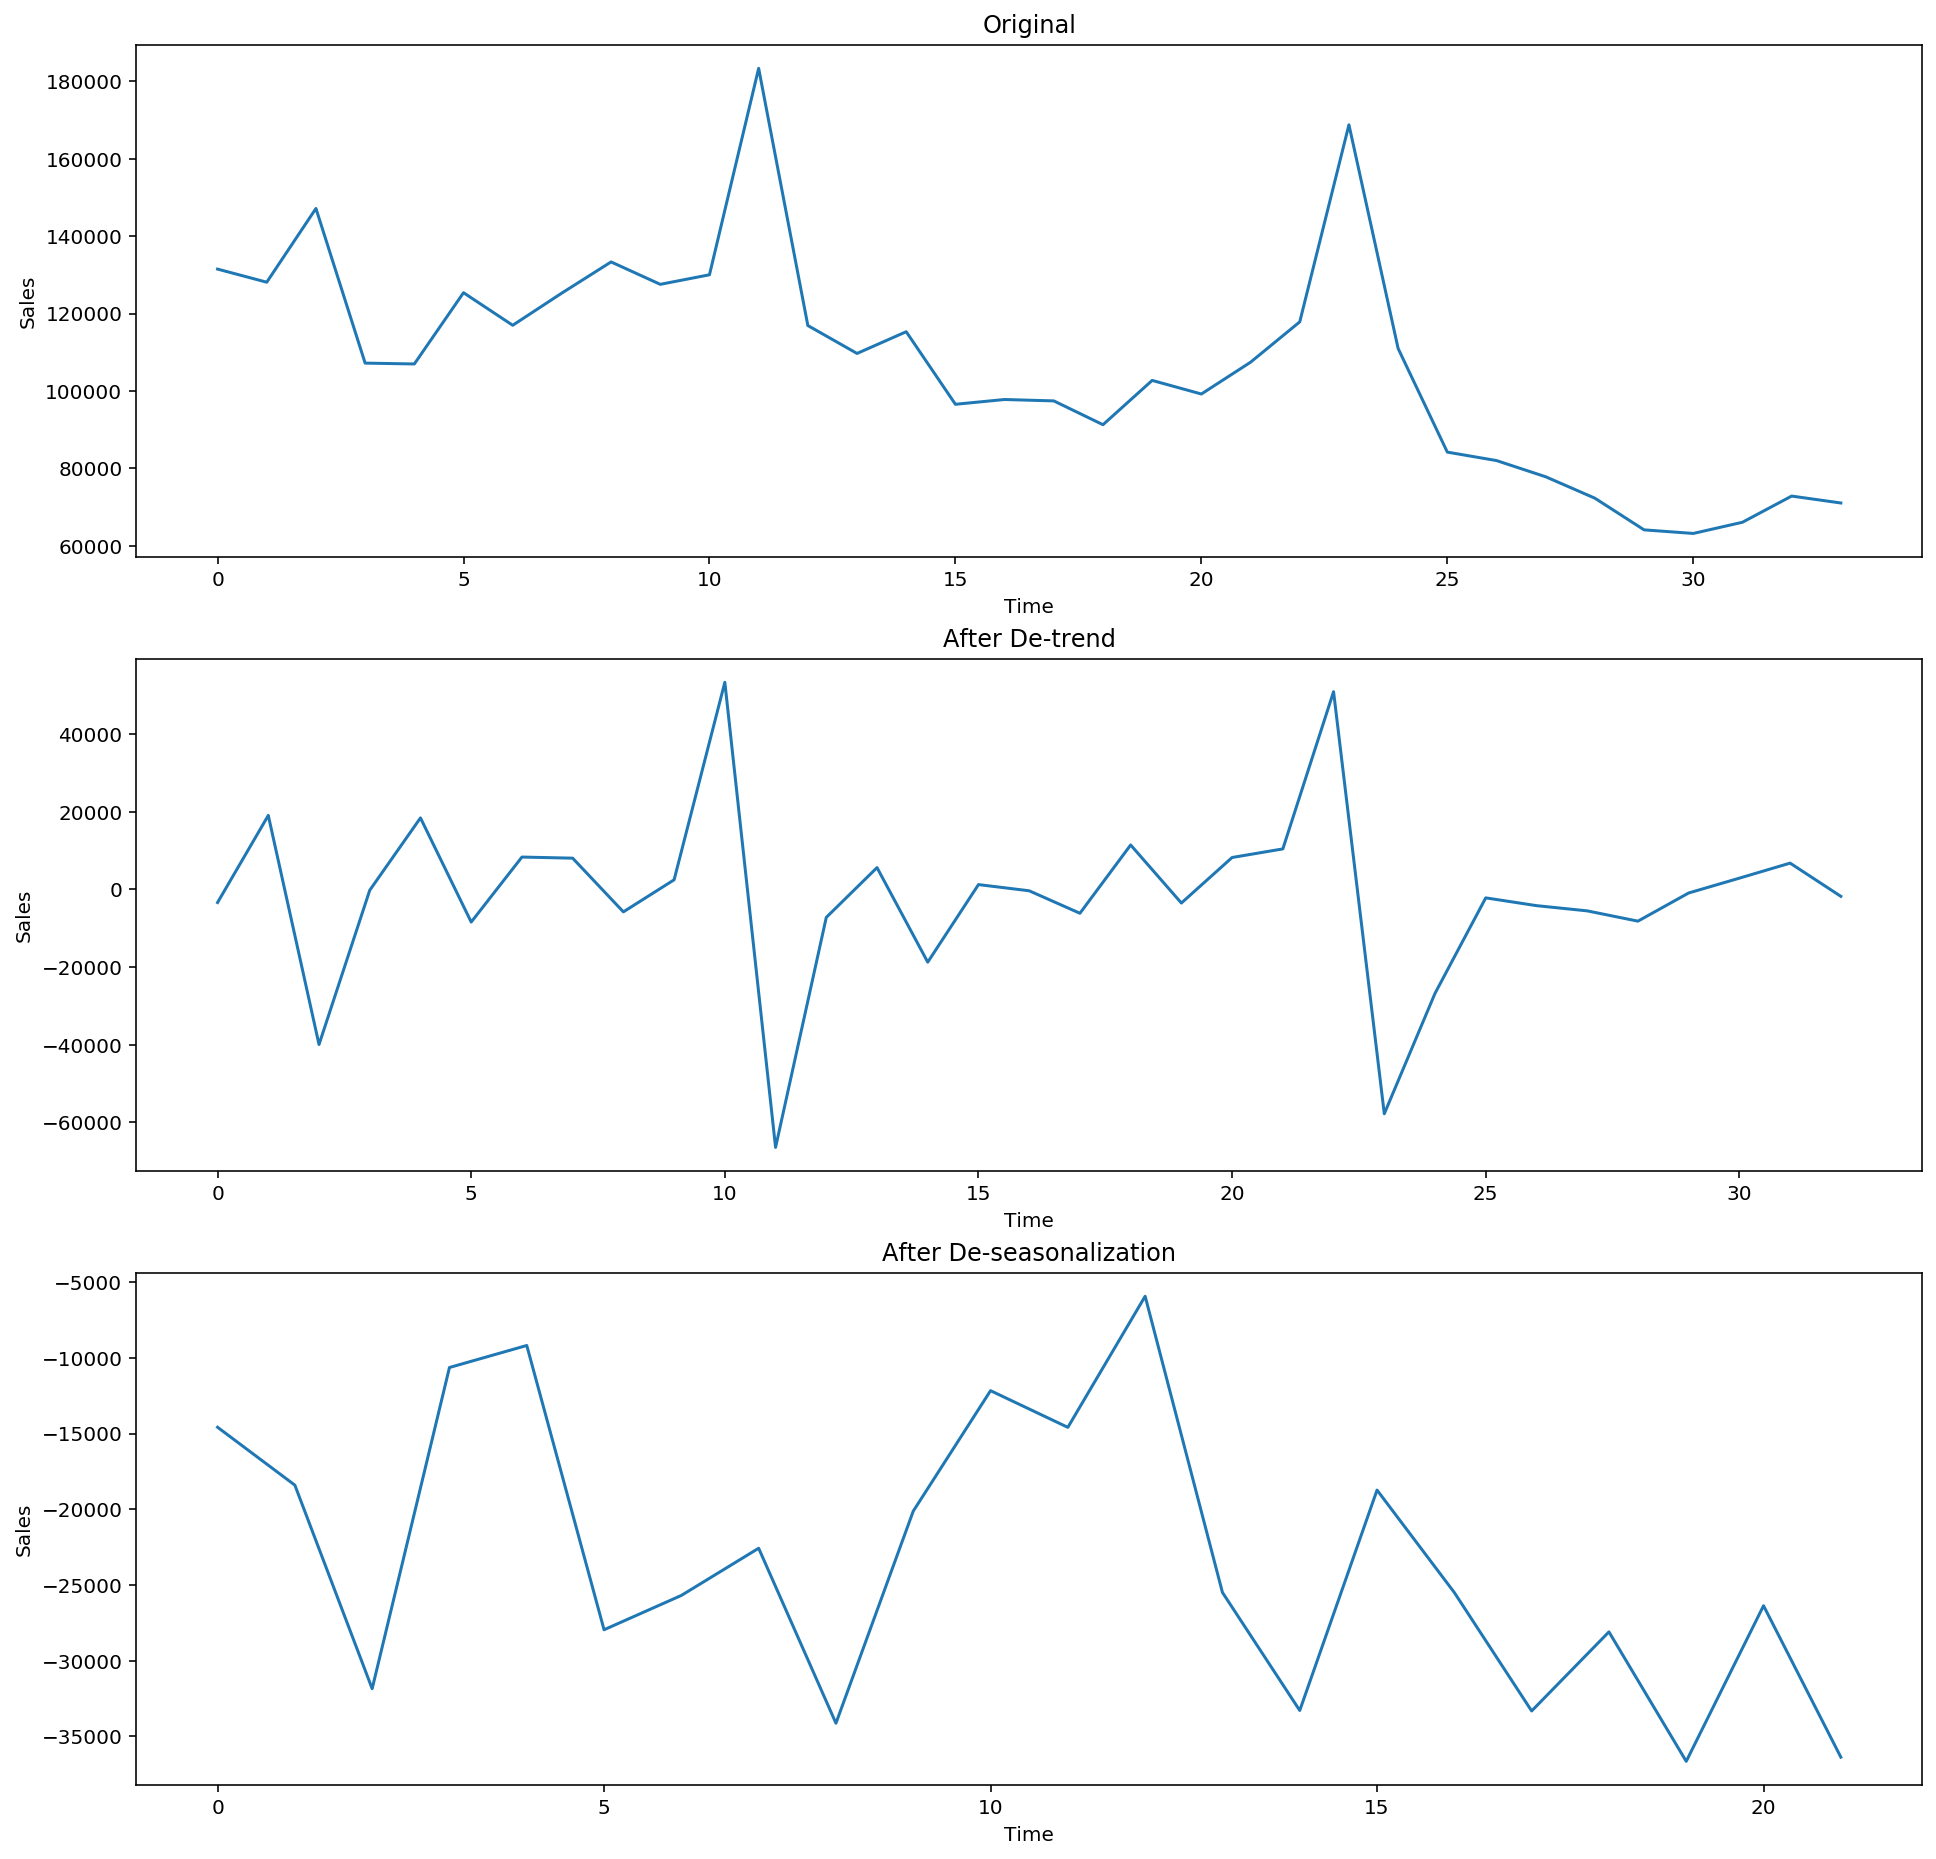

In [47]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # 계절성 주기를 12로 설정
plt.plot(new_ts)
plt.plot()

In [48]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


### 계절성 성분 삭제후 
- p-value 가 5 %이내가 됨
- 시불변성을 가정

# (참고) AR, MA, ARMA 모델 - 사용하지 않음
- TL: DR version of the models:

- MA - 다음 값은 이전 n 값의 이동 평균
- AR - 다음 값의 오차는(difference in mean) 이전 n 값의 오차의 함수로 표현
- ARMA - 위 둘을 동시에 고려

- 주어진 시계열이 MA인지 RA인지 파악해야 함

In [49]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

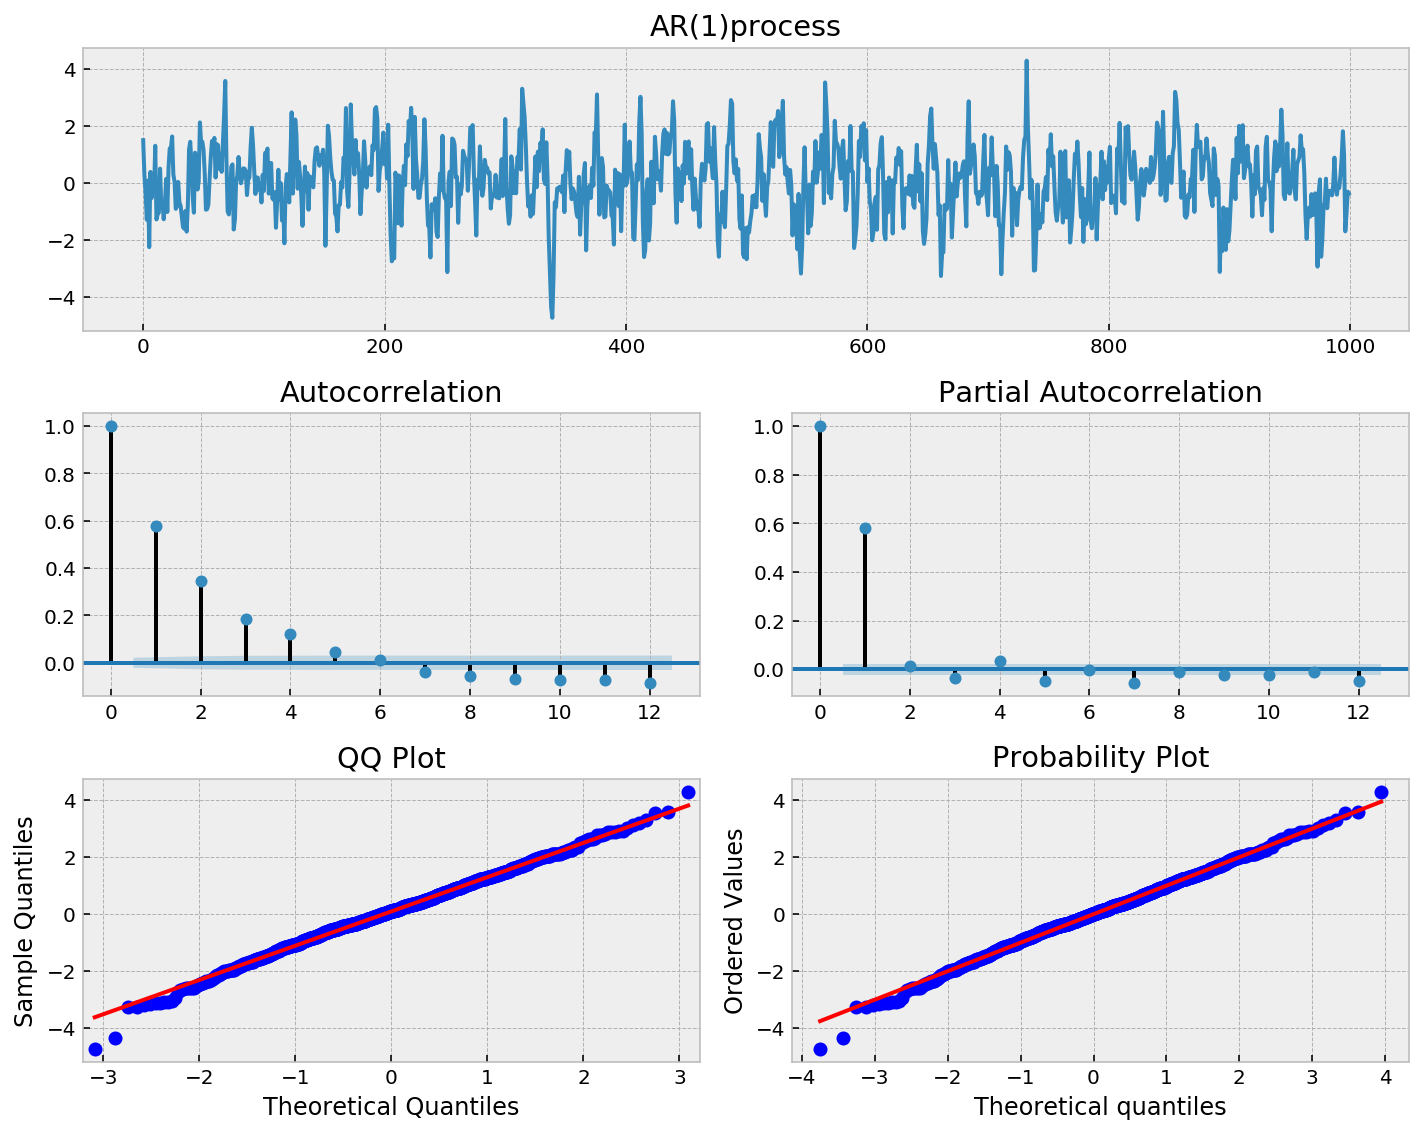

In [50]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

### AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

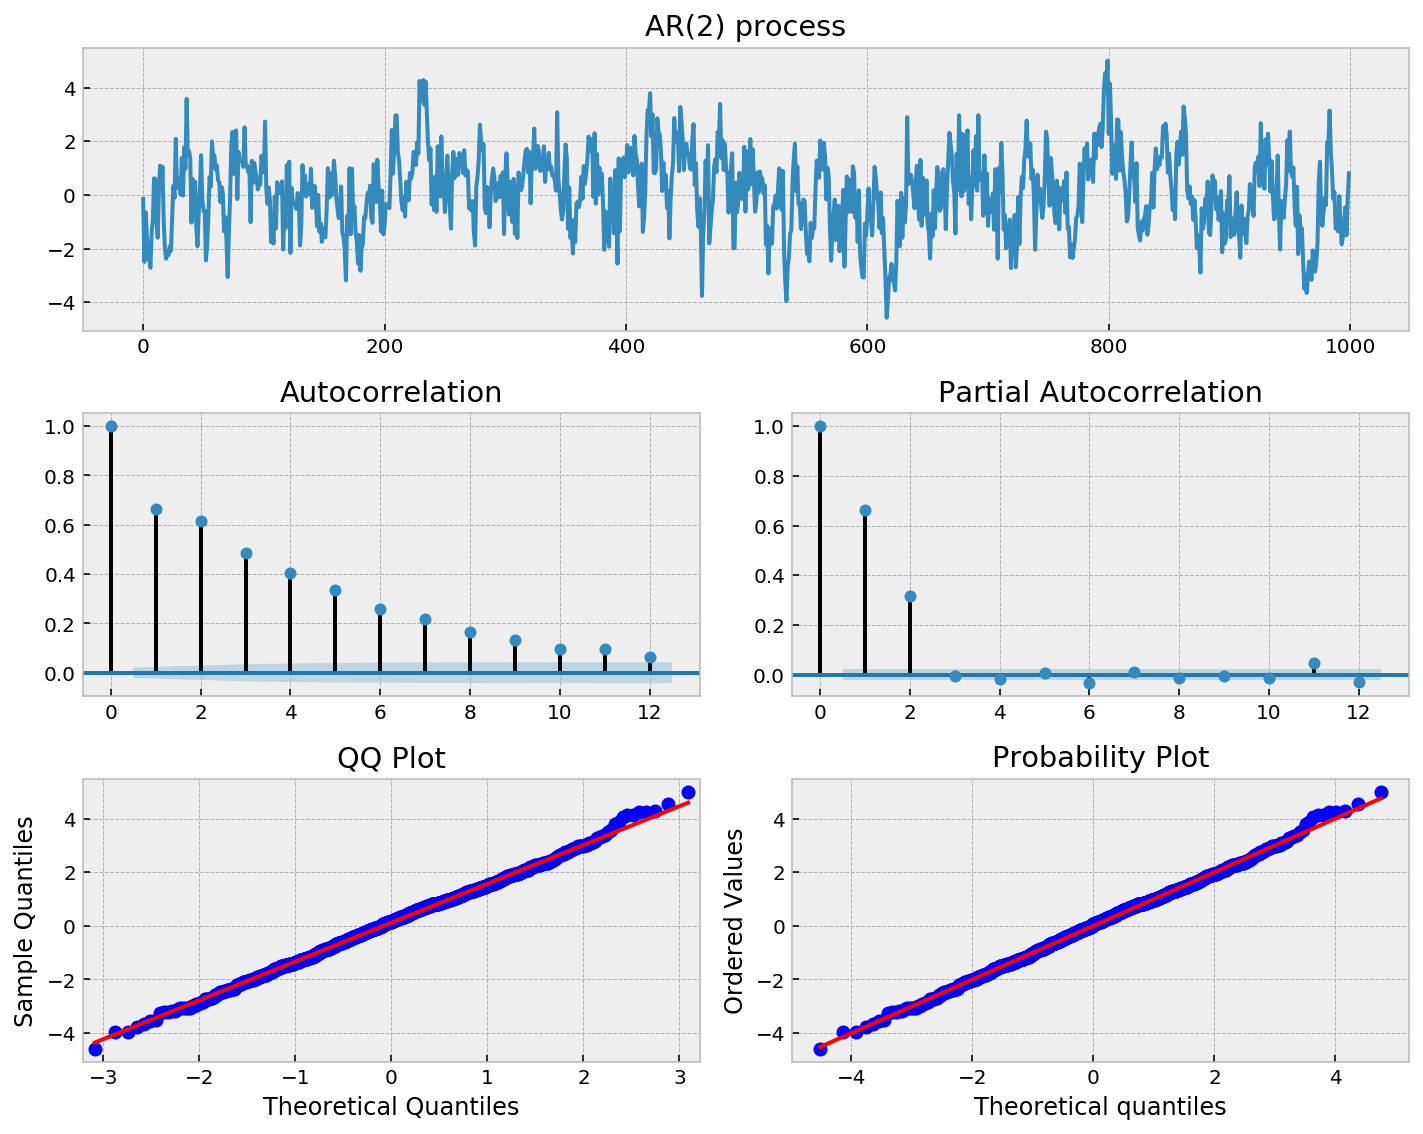

In [51]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

### AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

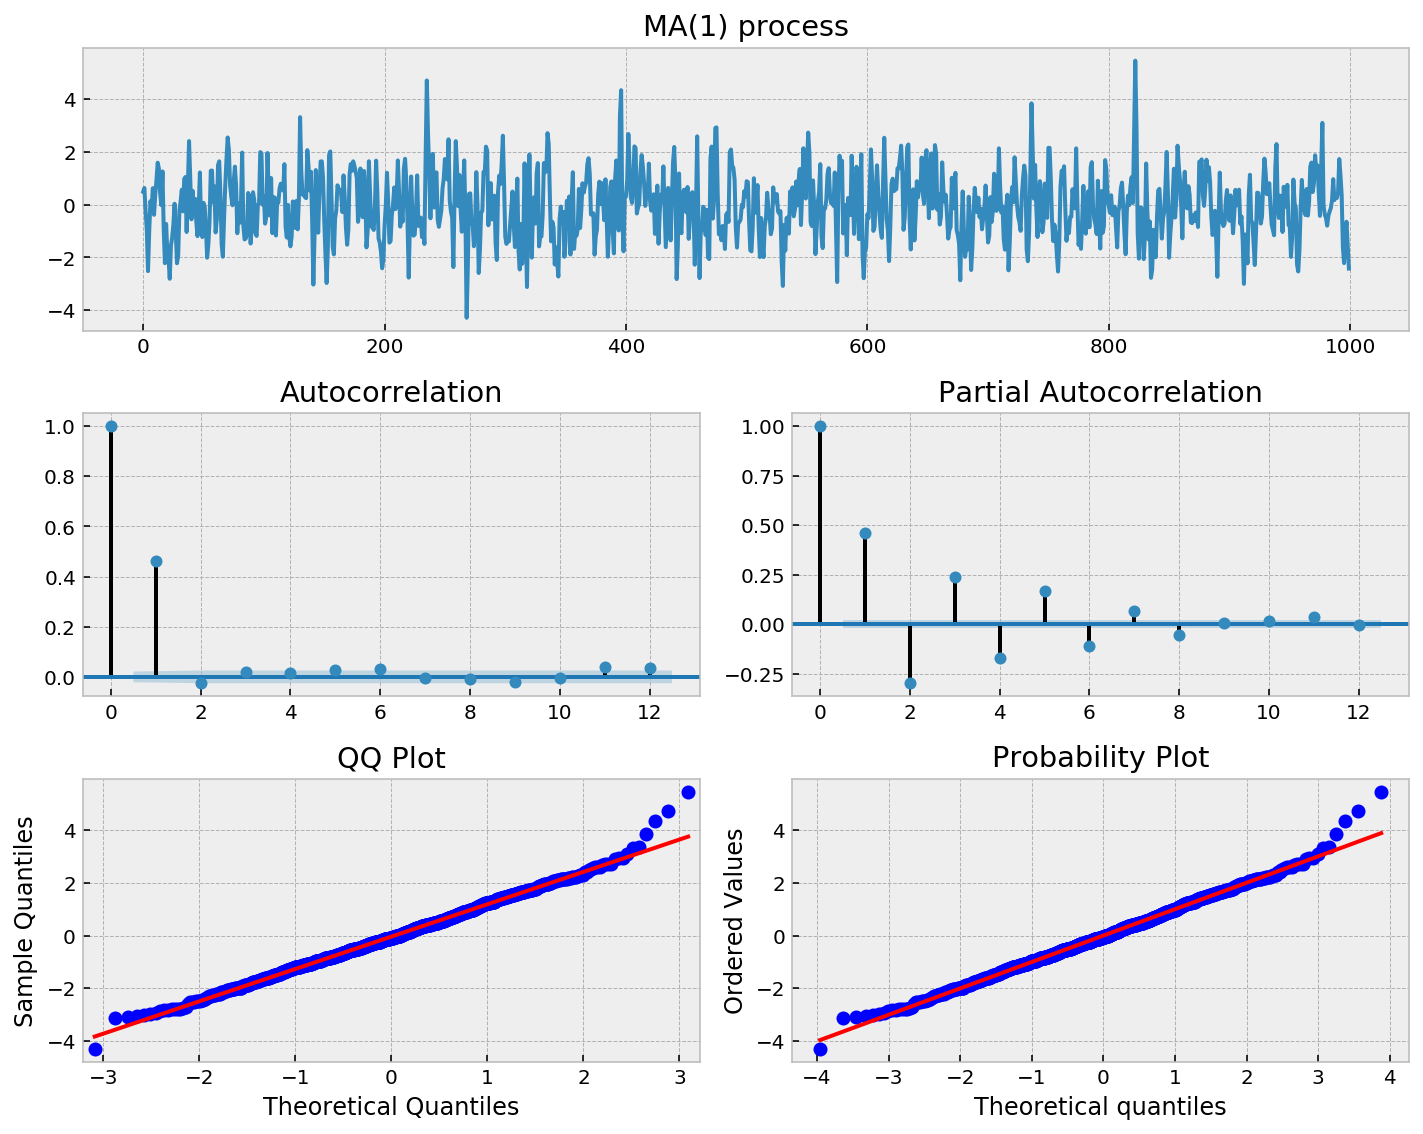

In [52]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

## MA(1) process -- has ACF cut off at lag=1

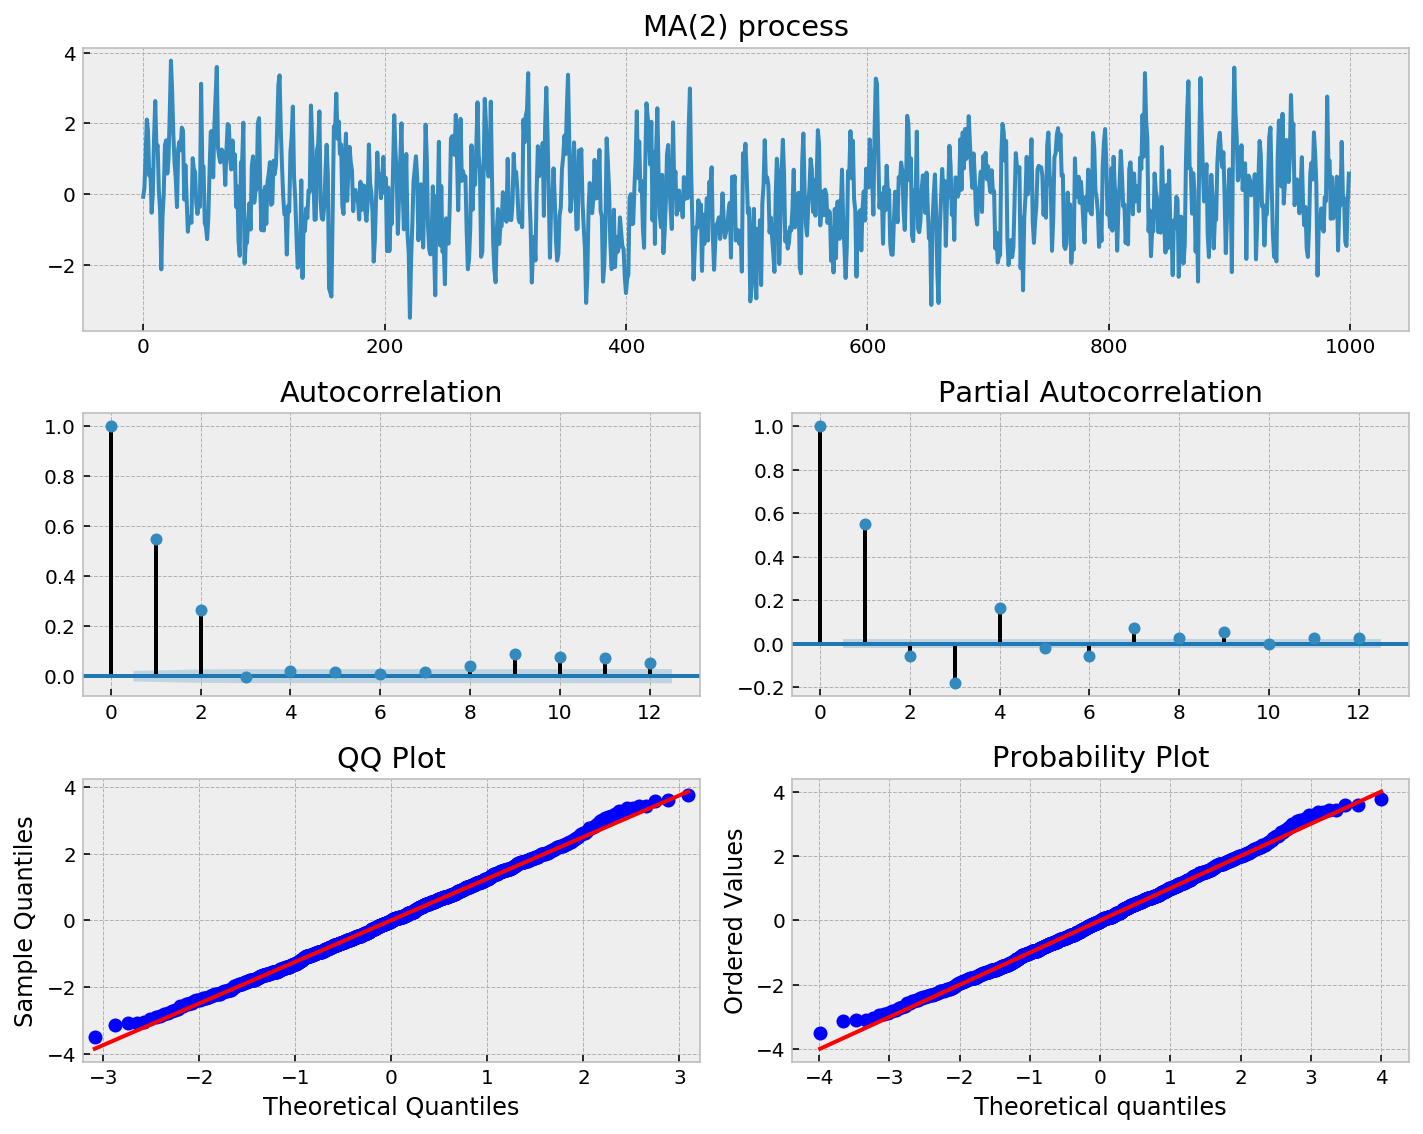

In [53]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

## MA(2) process -- has ACF cut off at lag=2

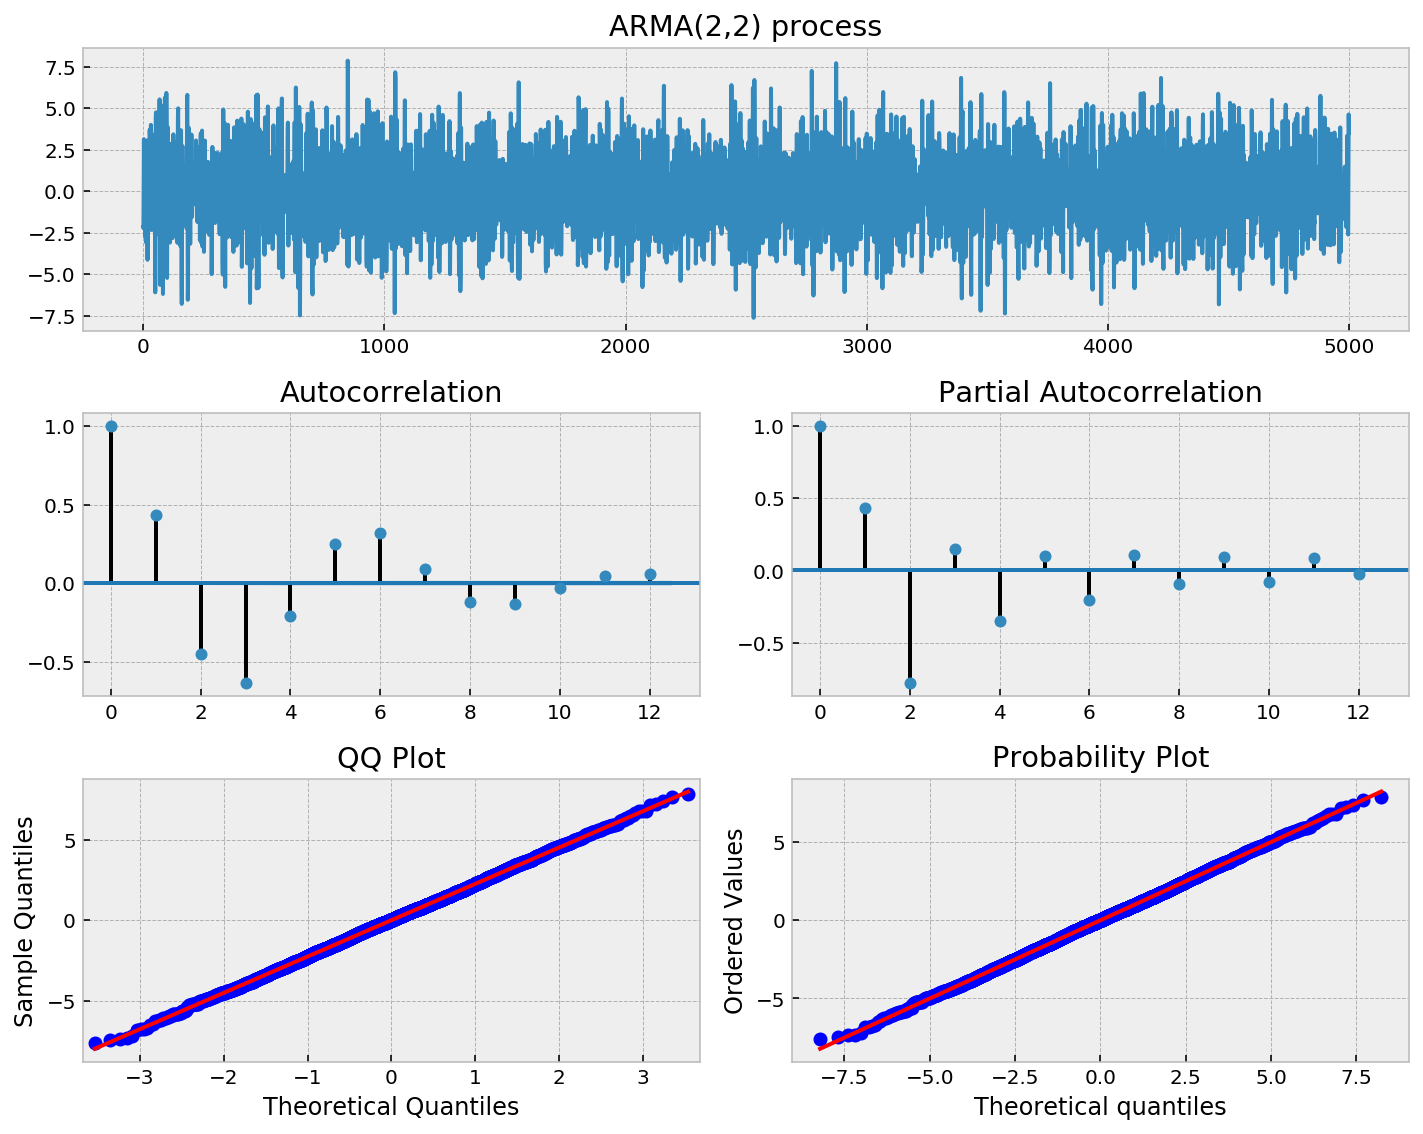

In [54]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

## Now things get a little hazy. Its not very clear/straight-forward.

A nifty summary of the above plots:

ACF Shape	| Indicated Model |
-- | -- |
Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model |
Alternating positive and negative, decaying to zero	Autoregressive model. |  Use the partial autocorrelation plot to help identify the order. |
One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
Decay, starting after a few lags |	Mixed autoregressive and moving average (ARMA) model. | 
All zero or close to zero | Data are essentially random. |
High values at fixed intervals | Include seasonal autoregressive term. |
No decay to zero |	Series is not stationary |


## Let's use a systematic approach to finding the order of AR and MA processes.

In [55]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: 15326.68109 | order: (2, 2)


## We've correctly identified the order of the simulated process as ARMA(2,2). 

### Lets use it for the sales time-series.


In [56]:
#
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: 472.99703 | order: (1, 1)


In [57]:
# Simply use best_mdl.predict() to predict the next values

In [14]:
# adding the dates to the Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


# Prophet: 

- 페이스북이 제공한 시계열 분석 도구
- ARIMA는 최적 파라미터 찾는 것이 어렵다
- 더욱이 상점-상품의 조합의 수가 매우 많으므로 이들 각각 경우의 최적 파라미터 찾기는 더 어렵다
- sklearn 처럼 사용할 수 있는 라이브러리
- 다음의 네가지 특징이 있다.

 - 선형 또는 로지스틱 트렌드 반영(트렌드의 변화를 changepoints를 설정함으로써 쉽게 검출()
 - 푸리에 시리즈를 이용한 연간 계절성 모델
 - 더미 변수를 사용한, 주간 계절성 처리
 - 공휴일 등을 사용자 지정 가능

**참고자료**
* https://www.youtube.com/watch?v=95-HMzxsghY
* https://facebook.github.io/prophet/docs/quick_start.html#python-api
* https://research.fb.com/prophet-forecasting-at-scale/
* https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851

In [15]:
!pip install fbprophet

In [16]:
from fbprophet import Prophet
# 환경설정에서 데이터프레임 필요, 데이터 ds와 값 y
ts.columns=['ds','y']
model = Prophet(yearly_seasonality=True)
# 연간 계절성만 반영
model.fit(ts) #fit the model with your dataframe

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957161,80122.491905,86232.324909
35,2015-12-01,125513.062787,122462.446561,128880.055727
36,2016-01-01,75625.688443,72305.426118,78478.842309
37,2016-02-01,40109.144323,36928.259120,43428.265602
38,2016-03-01,76664.084516,73684.377626,79900.748474


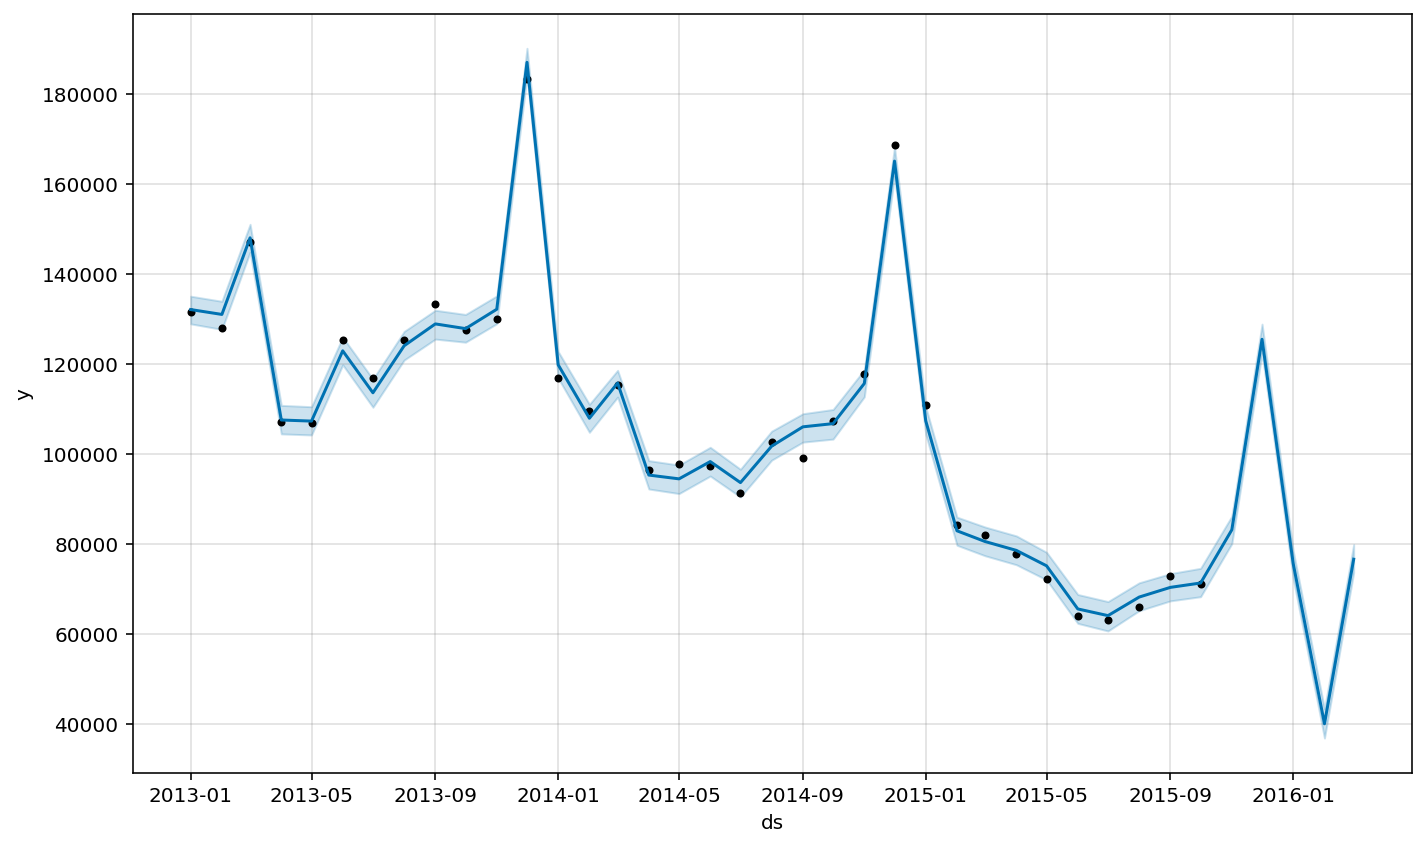

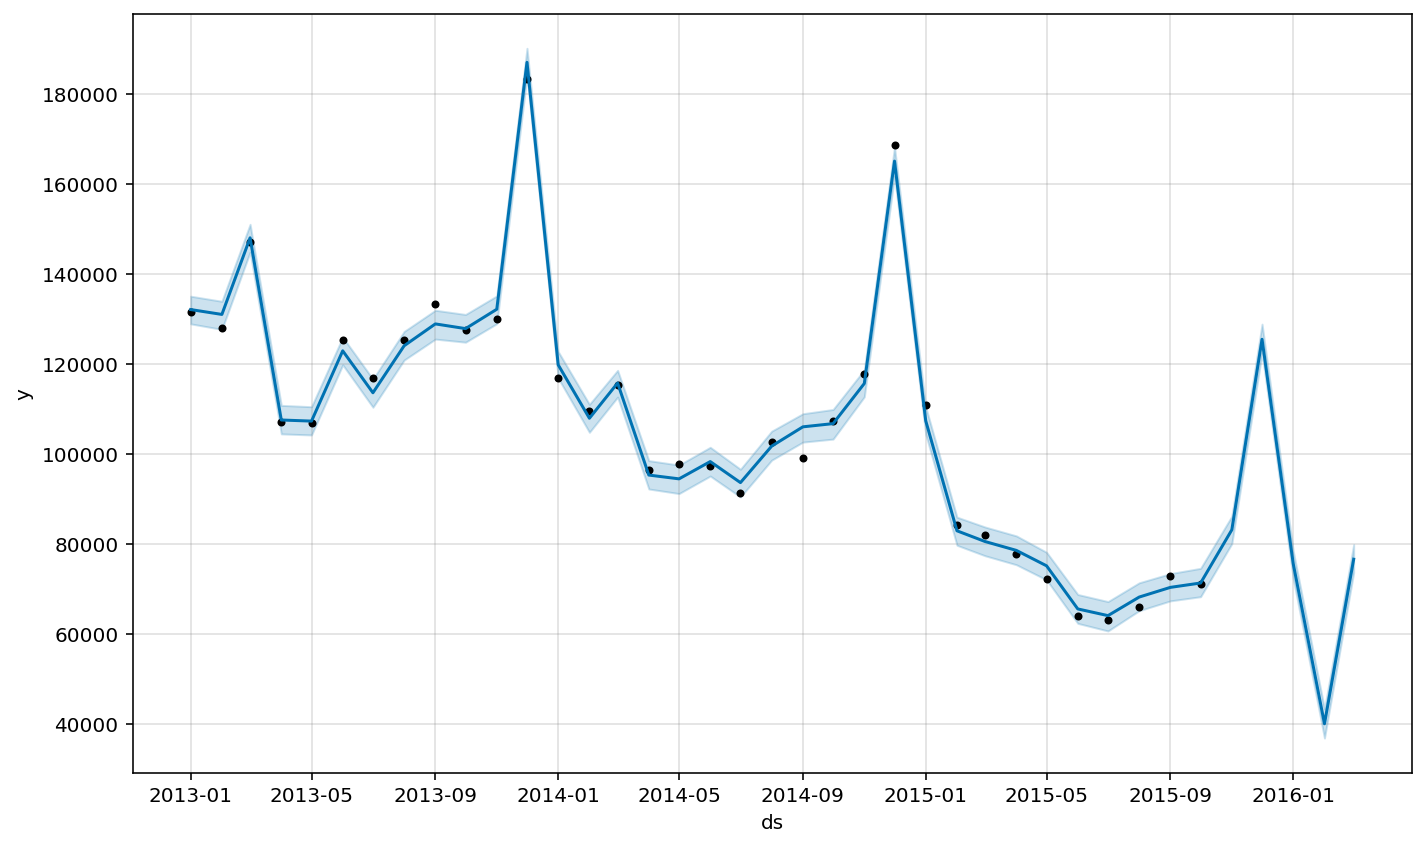

In [18]:
model.plot(forecast)

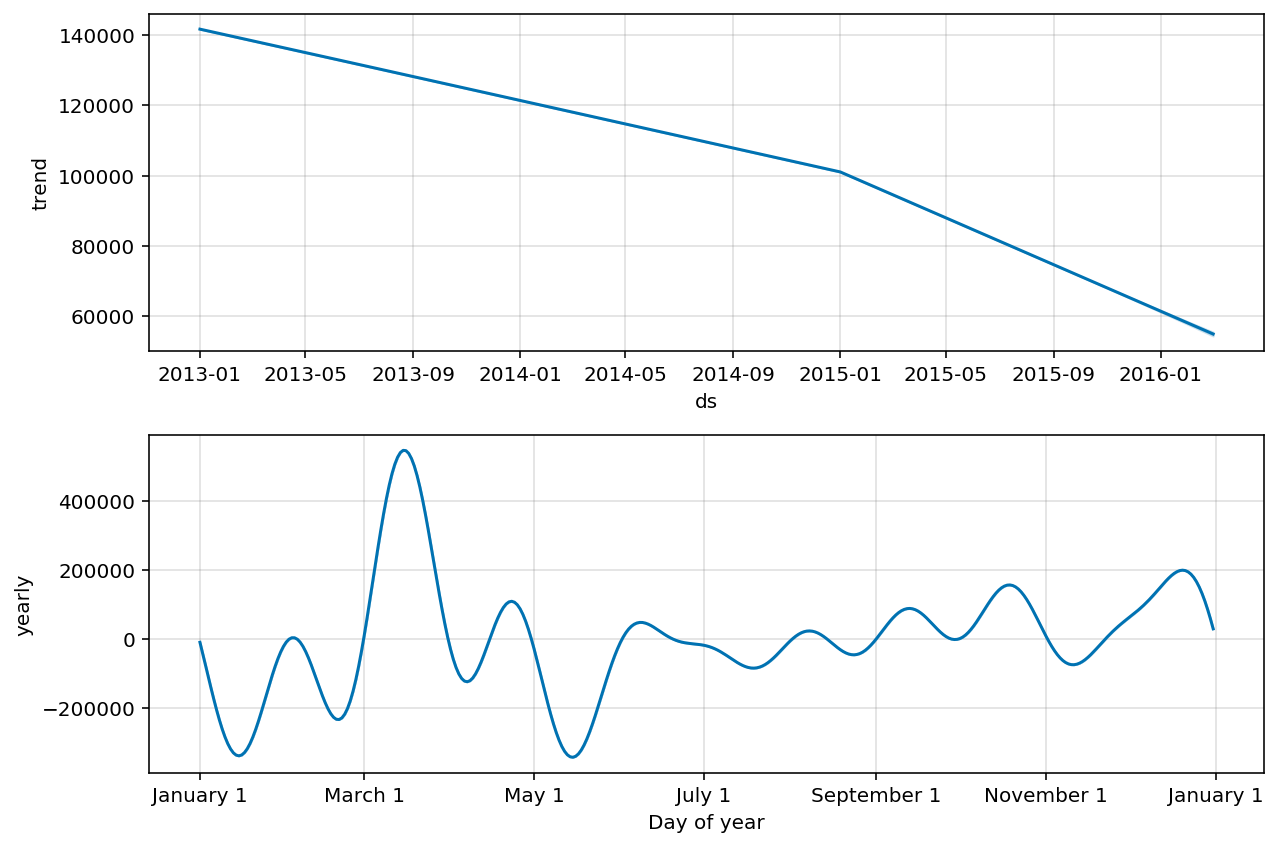

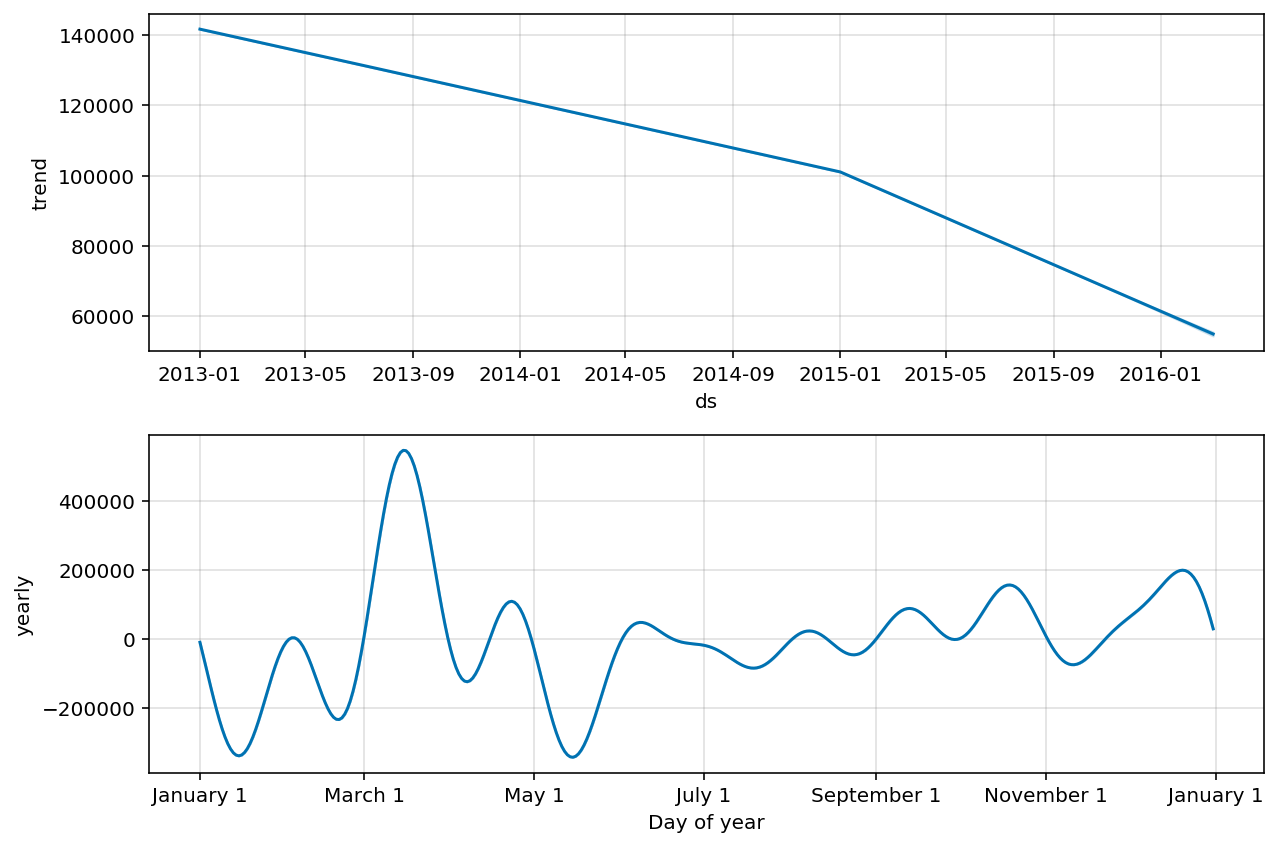

In [64]:
model.plot_components(forecast)

- 앞에서 구한 트렌드와 계절성과 유사한 결과를 얻었다.


# 참고
## Hierarchical time series:
### Bottom up approach:

- 하위 단계의 시계열 예측후 합산을 구한다
- 잃는 저보는 없으나, 노이지가 많을 수 있다.

### Top down approach:
- 상위 단계의 예측후 하위 단계의 가중치를 구하여 나눈다
 - 기존 값의 평균을 구하는 방법
 - 회귀 분석으로 가중치 변화를 예측하는 방법
 
### Middle out:
- 중간 지점을 정하고 위의 두가지를 모두 적용하는 방법
    
### Optimal combination approach:
- 각 계층에 대한 모든 예측을 수행하는 방법 (독립적으로)

### 주어진 데이터
- 22170 상품과 60 상점으로 경우의 수가 많다
- Prophet을 사용한다
- 고려사항
 - 모든 상점이 같은 품목을 취급하지 않는다
 - 신상품이 들어오면?
 - 상품이 없어지면?

In [65]:
total_sales=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [66]:
# get the unique combinations of item-store from the sales data at monthly level
monthly_sales=sales.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
# arrange it conviniently to perform the hts 
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

shop_id      index     0                                             ...  \
item_id               30    31    32   33    35   36   40   42   43  ...   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 424125 columns]

In [73]:
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

~16s for 10 predictions. We need a million predictions. This would not work out.

# Middle out:
- 상점 수준에서 예측

In [76]:
monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

shop_id,index,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,...,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,...,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,...,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,...,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,...,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0


In [77]:
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [70]:
#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
       predictions = np.concatenate((predictions, f2), axis = 1)

In [71]:
predictions_unknown=predictions[-1]
predictions_unknown

array([  240.81393195,   116.28589275,  1107.78659337,   888.86026488,
        1465.17303457,  1311.88427114,  2553.96936999,  1874.98195507,
        -103.61300882,   581.58036265,   706.7584699 ,    29.36442882,
        3684.86252505,  -533.0132714 ,  1125.91098769,  2102.61634463,
        1235.63309741,  1620.53162096,  1507.99916018,  1901.99325378,
        -681.46089581,  2090.00319908,  1744.75682681,  -742.48402521,
        2329.36463879,  6642.37729599,  1533.4592119 ,  6841.03563702,
        4470.31106099,   145.57284594,   296.75212005,  8209.01137591,
       -1266.81428445,   775.5725663 ])